# Detecting Anomales in User-Reviews

### Libraries
- **SQLite3**
- **Matplotlib**:
2D plotting library used to produce figures.
- **Numpy**:
Used for scientific computing; linear algebra, Fourier transform, etc.
- **Pandas**:
Provides data structures and data analysis tools.

### First Steps
1. Import the libraries mentioned above.
2. Define the fully qualified path name to our database file.
3. Define a conn(ection) variable with a link to the database file.

In [1]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

apps = ['Facebook',
        'Instagram',
        'Waze',
        'Whatsapp',
        'Calorie Counter MyFitnessPal',
        'Pinterest',
        'Fitbit']

applications = {}

db_path = "/Users/gohost/Projects/anomales/jupyter-notebooks/user-reviews/reviews_with_truthset.db"

conn = sqlite3.connect(db_path)
conn.text_factory = lambda b: b.decode(errors = 'ignore')

### Data Exploration: Project on Cultural Bias in User-Reviews
#### Data
1. 68,000 user reviews from Twitter

#### Applications Reviewed
- Facebook
- Instagram
- Waze
- WhatsApp
- Calorie Counter MyFitnessPal
- Pinterest
- Fitbit

#### Structuring
- Collect __all__ data and put in DataFrame `full_df`
- Collect data for each application; columns: **app_name**, **date**, and **score** and put in DataFrame.
- Compile per app DataFrame in a dictionary: `app_dfs = { 'app_name' : app_df }`
- Make a list of all row lengths per app in `row_counts`

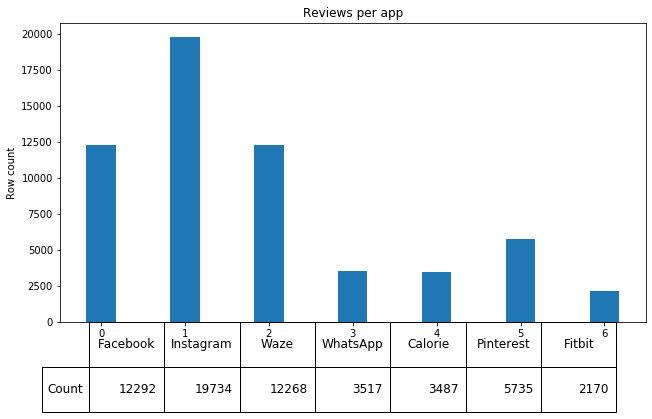

<Figure size 1120x800 with 0 Axes>

,app_name,user_id,user_name,country,version,score,topic,review,url,review_id,Year,Month,Weekday Name
date,,,,,,,,,,,,,
2017-06-30,Facebook,46172917,Christophernaylor,Canada,99,1,Fix this app,You continually update this app and increase t...,https://itunes.apple.com/WebObjects/MZStore.wo...,2,2017,6,Friday
2017-06-30,Facebook,111322700,aenewman,Canada,96,1,Really?,The new comments section on videos is the wors...,https://itunes.apple.com/WebObjects/MZStore.wo...,3,2017,6,Friday
2017-06-30,Facebook,49523188,Mamankajuj,Canada,99,5,Useful,Useful,https://itunes.apple.com/WebObjects/MZStore.wo...,4,2017,6,Friday
2017-06-30,Facebook,348391269,Upsetuser99,Canada,99,1,Icons,I don't enjoy that the icons on the bottom for...,https://itunes.apple.com/WebObjects/MZStore.wo...,5,2017,6,Friday
2017-06-30,Facebook,109196171,Bugbugkrys,Canada,96,1,Annoying,Updated the app despite my gut feeling not too...,https://itunes.apple.com/WebObjects/MZStore.wo...,6,2017,6,Friday


In [2]:
full_query = "SELECT * FROM reviews";
full_df = pd.read_sql_query(full_query, conn, index_col=['date'], parse_dates=['date'])

# Use pandas to add columns Weekday Name, Month, and Year to the full DataFrame
full_df['Year'] = full_df.index.year
full_df['Month'] = full_df.index.month
full_df['Weekday Name'] = full_df.index.weekday_name

# Create a DataFrame for each application, with columns 'app_name', 'date', and 'score', compile in dictionary
app_dfs = {}
for app in apps:
    query = "SELECT app_name, date, score FROM reviews WHERE app_name='%s'" % app
    app_dfs[app] = pd.read_sql_query(query, conn, index_col=['date'], parse_dates=['date'])

row_counts = []
for app in apps:
    query = "SELECT COUNT(*) FROM reviews WHERE app_name ='%s'" % app
    rows = pd.read_sql_query(query, conn)
    row_counts.append(rows.iloc[0]['COUNT(*)'])
    
# Make a table and barplot showing the row counts per app
columns = ('Facebook', 'Instagram', 'Waze', 'WhatsApp', 'Calorie', 'Pinterest', 'Fitbit')
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 5.5)
rowcount_table = plt.table(cellText=[row_counts],
                           rowLabels=['Count'],
                           colLabels=columns,
                           loc='bottom',
                           bbox=[0.05, -0.3, 0.9, 0.3])
rowcount_bar = plt.bar(np.arange(7),
                       row_counts,
                       0.35)
plt.ylabel('Row count')
plt.title('Reviews per app')
fig=plt.figure(figsize=(14, 10), dpi= 80, facecolor='w', edgecolor='w')
rowcount_table.set_fontsize(18)

plt.show()
full_df.head(5)

# Preparing Time Series
## Adding Columns to the Data Set: Year, Month, Weekday Name

Pandas data structures for working with dates and times (__we already added these columns to the full dataframe__).

- A single point in time is represented as a _Timestamp_
- _DatetimeIndex_ is the core data structure that powers Pandas time series functionality

In our SQL queries, we indexed by the ['date'] column, which made it into a DatetimeIndex. This is what allows us to leverage the pandas time series functionality.

In [3]:
# The specific formatting of our 'date' column in table 'reviews'
form = '%Y-%m-%d'
app_ts_dict = {}

# Iterate over all DataFrames and add columns year, month, weekday
for app, df in app_dfs.items():
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Weekday Name'] = df.index.weekday_name
    app_ts_dict[app] = df;
    
# Display sample
app_ts_dict['Instagram'].sample(5, random_state=0)

,app_name,score,Year,Month,Weekday Name
date,,,,,
2017-05-01,Instagram,1,2017,5,Monday
2017-05-15,Instagram,1,2017,5,Monday
2017-05-23,Instagram,3,2017,5,Tuesday
2017-06-30,Instagram,3,2017,6,Friday
2017-06-03,Instagram,5,2017,6,Saturday


# Visualizing Time Series
Here we want to make visualizations of our data, indexed by time, and want to show:
1. Average score per day _line plot_
2. Average amount of 'reviews per day

To make each application more recognizable throughout our visualizations, we compile various properties for them here, which are re-used whenever possible in the plots.

In [4]:
applications = {
    'Facebook' : {
        'color' : 'blue',
        'linestyle' : 'solid'
    },
    'Instagram' : {
        'color' : 'purple',
        'linestyle' : 'solid'
    },
    'Waze' : {
        'color' : 'teal',
        'linestyle' : 'solid'
    },
    'Calorie' : {
        'color' : 'brown',
        'linestyle' : 'solid'
    },
    'Pinterest' : {
        'color' : 'red',
        'linestyle' : 'solid'
    },
    'Fitbit' : {
        'color' : 'green',
        'linestyle' : 'solid'
    },
    'Whatsapp' : {
        'color' : 'lime',
        'linestyle' : 'solid'
    }
}

## Average score per day
1. Select a slice of time with `dataframe.loc['2017-01-20':'2017-05-20]`
2. Per day, sum all scores and divide by number of rows

First we evaluate the earliest and latest dates of the reviews, in order to select a suitable time slice.

OLDEST and MOST RECENT review PER APP
	Facebook
	First: 2017-05-01 Latest: 2017-06-30
	Instagram
	First: 2017-05-01 Latest: 2017-06-30
	Waze
	First: 2017-05-01 Latest: 2017-06-30
	Whatsapp
	First: 2017-05-01 Latest: 2017-06-30
	Calorie Counter Myfitnesspal
	First: 2017-05-01 Latest: 2017-06-30
	Pinterest
	First: 2017-05-01 Latest: 2017-06-30
	Fitbit
	First: 2017-05-01 Latest: 2017-06-30


NUMBER OF ROWS PER APP in time slice '2017-05-01':'2017-05-30'
	Facebook = 5937
	Instagram = 9405
	Waze = 7076
	Whatsapp = 1846
	Calorie Counter MyFitnessPal = 1836
	Pinterest = 2217
	Fitbit = 1179




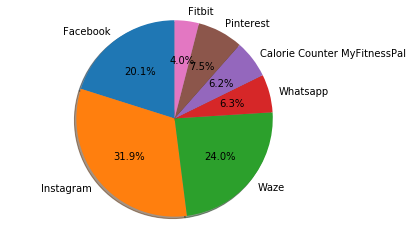

<Figure size 1120x800 with 0 Axes>

,app_name,score,Year,Month,Weekday Name
date,,,,,
2017-05-30,Waze,5,2017,5,Tuesday
2017-05-30,Waze,5,2017,5,Tuesday
2017-05-30,Waze,5,2017,5,Tuesday
2017-05-30,Waze,5,2017,5,Tuesday
2017-05-30,Waze,5,2017,5,Tuesday


In [5]:
app_min_max = {
    'Facebook' : (0,0)
}

for app, df in app_dfs.items():
    app_min_max[app] = (df.index.min().date(), df.index.max().date())

print("OLDEST and MOST RECENT review PER APP")
for app, min_max in app_min_max.items():
    print(f"\t{app.title()}")
    print(f"\tFirst: {min_max[0]} Latest: {min_max[1]}")
    
print("\n")

# Select 'slice' (... the month of May 2017)
app_ts_slices = {}
print("NUMBER OF ROWS PER APP in time slice '2017-05-01':'2017-05-30'")
for app, df in app_dfs.items():
    app_ts_slices[app] = df.loc['2017-05-01':'2017-05-30']
    print(f"\t{app} = {len(app_ts_slices[app].index)}")

print("\n")

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = []
sizes = []

for name, df in app_ts_slices.items():
    labels.append(name)
    sizes.append(len(df.index))

fig, ax = plt.subplots()
ax.pie(sizes,
       labels=labels,
       autopct='%1.1f%%',
        shadow=True,
       startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

fig=plt.figure(figsize=(14, 10), dpi= 80, facecolor='w', edgecolor='w')

plt.show()
app_ts_slices['Waze'].head(5)

# Getting Averages Values
Now we have collected rows from the table per app in the timeframe May 2017.

The variable `app_ts_slices` is a dictionary holding the desired timeframes, accessible by using the _app name_ as key.

We now proceed to:
- Iterate through each date index and sum all score rows belonging to that day -- per app --putting the average in a new list.
- Once we have lists with the average scores -- per app -- for every day of the time slice, we plot them together in a **line plot**.


In [6]:
form = "%Y-%M-%D"
date_range = pd.date_range("2017-05-01", "2017-05-30", freq="D") # MAY 2017

scores = {}

for app, df in app_ts_slices.items():
    scores[app] = []
    for single_date in date_range:
        score_sum = sum(df.loc[single_date]['score'])
        score_count = len(df.loc[single_date]['score'])
        average_score = (score_sum/score_count)
        scores[app].append(average_score)
  
scores_df = pd.DataFrame(scores, columns=apps)
scores_df['date'] = pd.to_datetime(date_range, format=form)
scores_df = scores_df.set_index(scores_df['date'])
scores_df = scores_df.rename(columns={'Calorie Counter MyFitnessPal': 'Calorie'}) # rename
scores_df = scores_df.drop("date", axis=1)
scores_df.head(10)

,Facebook,Instagram,Waze,Whatsapp,Calorie,Pinterest,Fitbit
date,,,,,,,
2017-05-01,1.582677,3.092715,4.419048,3.363636,4.587302,3.762500,3.540541
2017-05-02,1.481481,3.116838,4.346154,3.215190,4.478261,3.228070,3.148148
2017-05-03,1.440678,3.367521,4.473684,2.253623,4.765625,4.023529,3.658537
2017-05-04,2.549763,3.177083,4.074074,3.240000,4.714286,3.693333,3.531915
2017-05-05,2.498221,3.516014,3.975309,3.483516,4.536585,4.015385,3.680851
2017-05-06,1.726619,3.510373,4.514523,3.339286,4.653061,3.506024,3.552632
2017-05-07,1.568807,3.504854,4.643032,3.564516,4.431373,3.726190,4.090909
2017-05-08,1.910891,3.662745,4.593350,3.600000,4.526316,4.160494,3.962264
2017-05-09,1.773585,3.289655,4.560748,3.022727,4.493151,3.972603,3.775000


# Plotting Average Values
Building on the data processing we did in the previous step, we are now ready to plot the average values for score -- per day, per app -- in a line chart.

## Average score per day

1. Use _scores_df['date']_ as our X-axis
2. Use _scores_df['app_name']_ as our Y-axis (all the scores per app)

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Review score average, per day')

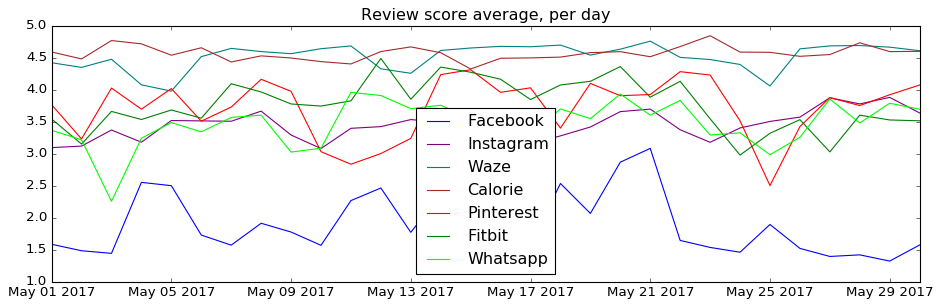

In [7]:
plt.style.use('classic')
fig=plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')

for app, prop in applications.items():
    plt.plot(scores_df.index,
    scores_df[app],
    label=app,
    color='%s' % applications[app]['color'],
    linestyle='%s' % applications[app]['linestyle'],
    linewidth=1)

plt.legend(loc='best')
plt.title("Review score average, per day")

## Reviews per day

In [8]:
app_reviews = {}

for app, df in app_ts_slices.items():
    app_reviews[app] = []
    for single_date in date_range:
        reviews = df.loc[single_date]['score']
        review_count = len(reviews.index)
        app_reviews[app].append(review_count)

reviews_df = pd.DataFrame(app_reviews, columns=apps)
reviews_df['date'] = pd.to_datetime(date_range, format=form)
reviews_df = reviews_df.set_index(scores_df.index)
reviews_df = reviews_df.rename(columns={'Calorie Counter MyFitnessPal': 'Calorie'}) # rename difficult column
reviews_df = reviews_df.drop("date", axis=1)
reviews_df.head(5)

,Facebook,Instagram,Waze,Whatsapp,Calorie,Pinterest,Fitbit
date,,,,,,,
2017-05-01,127,453,105,99,63,80,37
2017-05-02,108,291,78,79,69,57,27
2017-05-03,177,234,76,276,64,85,41
2017-05-04,211,288,81,125,49,75,47
2017-05-05,281,281,81,91,41,65,47


Text(0.5, 1.0, 'Number of reviews, per day')

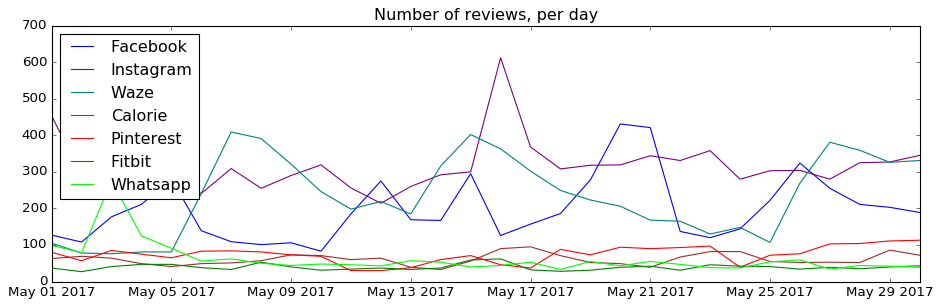

In [9]:
plt.style.use('classic')
fig=plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')

for app, prop in applications.items():
    plt.plot(reviews_df.index,
    reviews_df[app],
    label=app,
    color='%s' % applications[app]['color'],
    linestyle='%s' % applications[app]['linestyle'],
    linewidth=1)

plt.legend(loc='best')
plt.title("Number of reviews, per day")

## Average Amount of Reviews Per Day

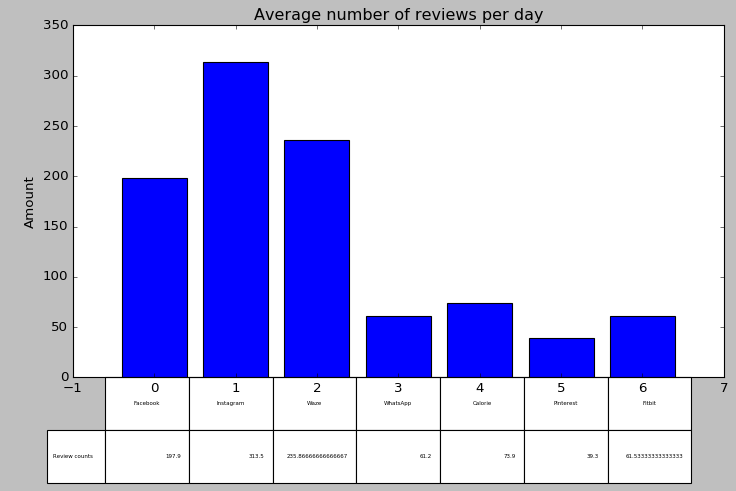

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 5.5)

avg_reviews = []
for app in applications.keys():
    total = sum(reviews_df[app])
    average = total/len(reviews_df.index)
    avg_reviews.append(average)
    
avg_reviews_table = plt.table(cellText=[avg_reviews],
                             rowLabels=['Review counts'],
                             colLabels=columns,
                             loc='bottom',
                             bbox=[0.05, -0.3, 0.9, 0.3])
avg_reviews_table.set_fontsize(10)

avg_reviews_bars = plt.bar(np.arange(7),
                          avg_reviews)

plt.ylabel('Amount')
plt.title("Average number of reviews per day")



plt.show()

# Boxplots of Average Score

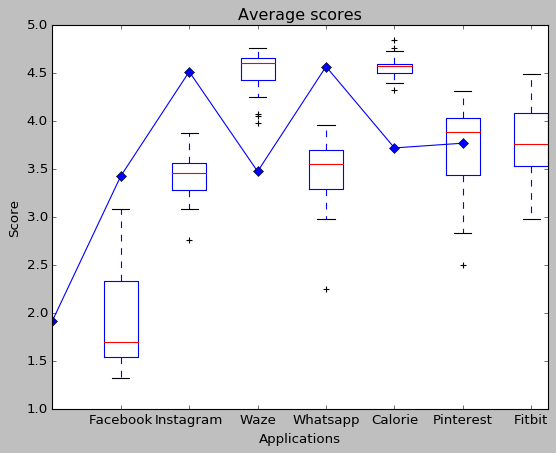

In [11]:
def boxplot(title, xname, yname, data, xlabels, means):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.boxplot(data, labels=xlabels)
    ax.plot(xlabels, means, marker='D')
    ax.set_ylabel(yname)
    ax.set_xlabel(xname)
    plt.show()
    
ll = []
for app_name in app_ts_slices.keys():
    ll.append(scores[app_name])

means = []
for x in ll:
    total = sum(x)
    mean = total/len(x)
    means.append(mean)
    
xlab = scores_df.columns.values.tolist()

boxplot("Average scores", "Applications", "Score", ll, xlab, means)